## **PETER4REC Model**

- **PeterRec** is a transfer learning architecture that was developed to address the issue of parameter inefficiency in fine-tuning large pretrained neural networks for downstream tasks.

- The idea behind **PeterRec** is to retain the knowledge of the pretrained network while minimizing the number of parameters that need to be optimized during the fine-tuning process. This is achieved by using a technique called **"parameter-efficient transfer learning,"** which involves selectively freezing and unfreezing layers of the pretrained network during fine-tuning.

- In this notebbok, I'll be using a **ratings_Beauty.csv** dataset from the Amazon Reviews data source. The dataset has four main attributes: UserID, ProductID, Rating, and Timestamp. The UserID is a one-of-a-kind identifier for each person, whereas the ProductID is a one-of-a-kind identifier for each product. The Rating property represents the rating given by a certain user for a particular product. Finally, the timestamp element keeps track of when the rating was supplied, it is from kaggle: https://www.kaggle.com/datasets/skillsmuggler/amazon-ratings.

## **Import libraries**

In [25]:
# import sys
# dir_path = # put the working dir (e.g., 'Cold-start-Recommendation-System' )
# if dir_path not in sys.path:
#     sys.path += [dir_path]

# sys.path 

In [2]:
# import needed libraries
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from torch.utils.tensorboard import SummaryWriter
from peter4pytorch import Peter4Coldstart
from  preprocesing import *
from train import *
import argparse
import random
import torch
import json
import joblib
import pickle
import torch.utils.data as data_utils
import scipy.sparse as sp
from pathlib import Path
from sklearn.metrics import log_loss, roc_auc_score
from torch.utils.data.distributed import DistributedSampler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from copy import deepcopy
import time
import torch.nn as nn
import torch.nn.utils.prune as prune

2023-07-28 20:32:29.493120: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-28 20:32:30.204049: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
def set_seed(seed, re=True):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    if re:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
    else:
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False

## **Arguments**

- **seed**: The random seed used for reproducibility.
- **task_name**: The name of the task being performed, specifically for cold start recommendation.
- **task_num**: The number of tasks being performed.
- **source_path**: The file path for the source data used in transfer learning.
- **target_path**: The file path for the target data used in transfer learning.
- **train_batch_size**: Batch size for training data.
- **val_batch_size**: Batch size for validation data.
- **test_batch_size**: Batch size for testing data.
- **sample**: The sampling strategy used to create the dataset.
- **max_len**: The maximum length of the input sequence.
- **item_min**: The minimum number of times an item should occur to be included in the dataset.
- **save_path**: The directory path to save the model checkpoint.
- **task**: The task identifier.
- **valid_rate**: The rate at which the validation is performed during training.
- **device**: The device to be used for training ('cuda' or 'cpu').
- **is_parallel**: A flag indicating whether to use multiple GPUs for training.
- **weight_decay**: The L2 regularization strength.
- **decay_step**: The decay step for StepLR.
- **gamma**: The gamma value for StepLR.
- **num_items**: The total number of items.
- **target_num**: The total number of target items for each user.
- **num_embedding**: The total number of source items.
- **k**: The number of items to measure the NDC@k metric (e.g., NDC@10).
- **metric_ks**: A list of integers specifying the ks for Metric@k evaluation.
- **best_metric**: The metric used to determine the best model (e.g., 'NDCG@20').
- **embedding_size**: The embedding size used in the model (for Nextitnet).
- **dilations**: A list of integers specifying the dilations for Nextitnet.
- **kernel_size**: The kernel size used in Nextitnet.
- **is_mp**: A flag indicating whether to use max-pooling in Nextitnet.
- **pad_token**: The padding token used in the input sequence.
- **temp**: The temperature used in Nextitnet.

**The following arguments are specifically related to the PETER model:**

- **is_pretrain**: An integer argument (0, 1, or 2) specifying the type of transfer learning to use with the PETER model. 0: mean transfer, 1: mean pretrain, 2: mean train the full model without transfer.
- **model_name**: A string argument specifying the name of the PETER model. This argument is used to identify the specific PETER architecture to be used.
- **epochs**: An integer argument representing the number of training epochs for the PETER model.
- **lr**: A float argument representing the learning rate for the PETER model.
- **hidden_size**: An integer argument specifying the size of hidden vectors in the PETER model.
- **block_num**: An integer argument specifying the number of transformer layers in the PETER model.
- **num_groups**: An integer argument specifying the number of transformer groups in the PETER model.
- **num_heads**: An integer argument specifying the number of heads for multi-attention in the PETER model.
- **dropout**: A float argument representing the dropout probability to use throughout the PETER model.
- **factor_num**: An integer argument specifying the factor number for the PETER model.

These arguments control various aspects of the PETER model architecture, such as the number of layers, hidden size, dropout rate, and learning rate, among others.

In [5]:
parser = argparse.ArgumentParser()

parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--task_name', default='cold_start')
parser.add_argument('--task_num', type=int, default=4)
parser.add_argument('--source_path', type=str, default='Tenrec/Beauty_ratings.csv')
parser.add_argument('--train_batch_size', type=int, default=16)
parser.add_argument('--val_batch_size', type=int, default=16)
parser.add_argument('--test_batch_size', type=int, default=16)
parser.add_argument('--sample', type=str, default='random')
parser.add_argument('--max_len', type=int, default=30)
parser.add_argument('--item_min', type=int, default=20)
parser.add_argument('--save_path', type=str, default='./checkpoint/')
parser.add_argument('--task', type=int, default=-1)
parser.add_argument('--valid_rate', type=int, default=100)

#transfer learning
parser.add_argument('--is_pretrain', type=int, default=1, help='0: mean transfer, 1: mean pretrain, 2:mean train full model without transfer')
parser.add_argument('--model_name', default='Peter4Coldstart')
parser.add_argument('--epochs', type=int, default=10)
parser.add_argument('--lr', type=float, default=0.001)
parser.add_argument('--device', default='cuda')  # cuda:0
parser.add_argument('--is_parallel', type=bool, default=False)
parser.add_argument('--weight_decay', type=float, default=0.0, help='l2 regularization') #0.008
parser.add_argument('--decay_step', type=int, default=5, help='Decay step for StepLR')
parser.add_argument('--gamma', type=float, default=0.6, help='Gamma for StepLR')
parser.add_argument('--num_items', type=int, default=1, help='Number of total items')
parser.add_argument('--target_num', type=int, default=1, help='Number of total target items for each user')
parser.add_argument('--num_embedding', type=int, default=1, help='Number of total source items')
parser.add_argument('--k', type=int, default=20, help='The number of items to measure the hit@k metric (i.e. hit@10 to see if the correct item is within the top 10 scores)')
parser.add_argument('--metric_ks', nargs='+', type=int, default=[5, 20], help='ks for Metric@k')
parser.add_argument('--best_metric', type=str, default='NDCG@10', help='Metric for determining the best model')

#model param
parser.add_argument('--hidden_size', type=int, default=128, help='Size of hidden vectors (model)')
parser.add_argument('--block_num', type=int, default=2, help='Number of transformer layers')
parser.add_argument('--num_groups', type=int, default=2, help='Number of transformer groups')
parser.add_argument('--num_heads', type=int, default=2, help='Number of heads for multi-attention')
parser.add_argument('--dropout', type=float, default=0.5,
                    help='Dropout probability to use throughout the model')
parser.add_argument('--bert_mask_prob', type=float, default=0.5,
                    help='Probability for masking items in the training sequence')
parser.add_argument('--factor_num', type=int, default=64)

#Nextitnet
parser.add_argument('--embedding_size', type=int, default=128, help='embedding_size for model')
parser.add_argument('--dilations', type=int, default=[1, 4], help='Number of transformer layers')
parser.add_argument('--kernel_size', type=int, default=3, help='Number of heads for multi-attention')
parser.add_argument('--is_mp', type=bool, default=False, help='Number of heads for multi-attention')
parser.add_argument('--pad_token', type=int, default=0)
parser.add_argument('--temp', type=int, default=10)
args = parser.parse_args("")

if args.is_parallel:
        torch.distributed.init_process_group(backend="nccl")
        torch.cuda.set_device(args.local_rank)
device = torch.device(args.device)
# if 'bert' in args.model_name:
set_seed(args.seed)
writer = SummaryWriter()
print(args)

Namespace(seed=0, task_name='cold_start', task_num=4, source_path='Tenrec/Beauty_ratings.csv', train_batch_size=16, val_batch_size=16, test_batch_size=16, sample='random', max_len=30, item_min=20, save_path='./checkpoint/', task=-1, valid_rate=100, is_pretrain=1, model_name='Peter4Coldstart', epochs=10, lr=0.001, device='cuda', is_parallel=False, weight_decay=0.0, decay_step=5, gamma=0.6, num_items=1, target_num=1, num_embedding=1, k=20, metric_ks=[5, 20], best_metric='NDCG@10', hidden_size=128, block_num=2, num_groups=2, num_heads=2, dropout=0.5, bert_mask_prob=0.5, factor_num=64, embedding_size=128, dilations=[1, 4], kernel_size=3, is_mp=False, pad_token=0, temp=10)


## **Model**

- Due to the **resources limitations**, such as low RAM and low GPU, make it difficult to execute the model with a lengthy training schedule. So, we have to limit the number of epochs and dataset size, which could have an impact on the model's performance to some degree.

- I have set the number of epochs to **10 epochs**.

- Also, I have choosen the **Rating 5** from our dataset, which is 80% from the dataset as a sample data to train it.
 
- Although, it would be **ideal** to increase the number of epochs for the model to have more time to learn from the data and improve its convergence, but Unfortunately we can't because of the limited resources.

In [13]:
# define take_sample due to the huge size of dataset
    
def take_sample(data_path):
    df = pd.read_csv(data_path)
    #train only the Rating = 5, which represents 80% of the dataset
    df = df[df.Rating==5]
    return df

# Define the path to the source data file
source_path = 'Tenrec/ratings_Beauty.csv'  
sample_data = take_sample(source_path)

### **Model's Evaluation Factors**

- **Recall** shows what percentage of relevant items the model can recommend. A higher recall means the model recommends more relevant things, which is usually better for recommendation models. A high recall ensures the model surfaces a wide range of relevant options.

- **NDCG** takes into account where relevant recommendations appear in the ranked list. It gives more importance to highly relevant items at the top. A higher NDCG indicates the model ranks relevant items higher up, which is important for the model's effectiveness. Having relevant recommendations at the top improves performance.

- **Training CE Loss** refers to the cross-entropy loss value of the training set after one epoch of training. Cross-entropy loss is a measure of the difference between the predicted and actual probability distributions.

- The **one epoch train time** and **one epoch val time** indicate the time it took to complete one epoch of training and one epoch of validation, respectively in seconds.

- The **train_time** and **val_time** are the sum of the individual epoch times.

### **First way of preprocessing**

========== Initialize Reset DataFrame Object ==========
========== Resetting user ids and item ids in DataFrame ==========
========== Initialize Reset DataFrame Object ==========
========== Resetting item ids in DataFrame ==========
Training CE Loss: 11.36473
one epoch train time: 245.62027859687805
++++++++++++++++++++ Valid Epoch 1 ++++++++++++++++++++
Train/Recall@20 0.02119140625 0
Train/NDCG@20 tensor(0.0098, device='cuda:0') 0
Train/Recall@5 0.008872767857142857 0
Train/NDCG@5 tensor(0.0064, device='cuda:0') 0
one epoch val time: 1103.4935710430145
one epoch train time: 1349.4527294635773
Training CE Loss: 10.58857
one epoch train time: 238.50347566604614
++++++++++++++++++++ Valid Epoch 2 ++++++++++++++++++++
Train/Recall@20 0.022823660714285713 1
Train/NDCG@20 tensor(0.0109, device='cuda:0') 1
Train/Recall@5 0.010309709821428571 1
Train/NDCG@5 tensor(0.0074, device='cuda:0') 1
one epoch val time: 1093.334266424179
one epoch train time: 1332.2655813694
Training CE Loss: 10.33188

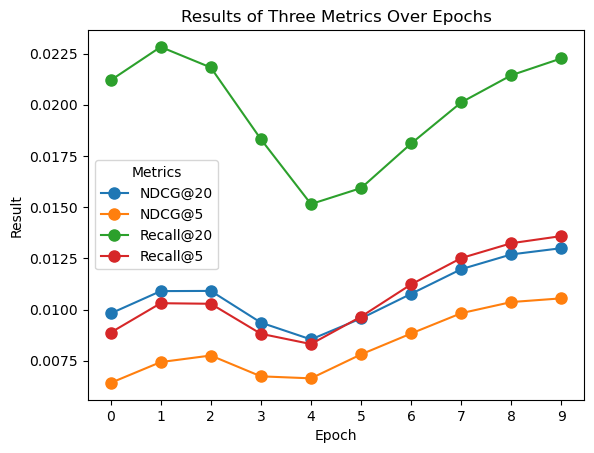

Peter4Coldstart(
  (item_embedding): Embedding(199006, 128, padding_idx=0)
  (residual_blocks): Sequential(
    (0): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(128, 128, kernel_size=(1, 3), stride=(1, 1))
      (ln1): LayerNorm((128,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(128, 128, kernel_size=(1, 3), stride=(1, 1), dilation=(2, 2))
      (ln2): LayerNorm((128,), eps=1e-08, elementwise_affine=True)
    )
    (1): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(128, 128, kernel_size=(1, 3), stride=(1, 1), dilation=(4, 4))
      (ln1): LayerNorm((128,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(128, 128, kernel_size=(1, 3), stride=(1, 1), dilation=(8, 8))
      (ln2): LayerNorm((128,), eps=1e-08, elementwise_affine=True)
    )
    (2): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(128, 128, kernel_size=(1, 3), stride=(1, 1))
      (ln1): LayerNorm((128,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(128, 128, kernel_siz

In [15]:
# define the paths to the target and source data files
args.source_path = 'Tenrec/ratings_Beauty.csv' 
args.item_min = 2
args.target_num = 1

train_loader, val_loader, test_loader = process_dataV5(args)

model = Peter4Coldstart(args)
trainV2( model, train_loader, val_loader, writer, args) 

#### **Observations**



- The model's performance improves over the course of the training process. This is evident from the decrease in the cross-entropy loss and the increase in the Recall@20, NDCG@20, Recall@5, and NDCG@5 metrics with each training epoch.

- At the beginning of the training, the model's **cross-entropy loss** is  11.36473, indicating poor performance. However, as training progresses, the loss decreases significantly reaching 2.56333 after 10 epochs, suggesting that the model is becoming more accurate in its predictions.

- Similarly, the Recall@20, NDCG@20, Recall@5, and NDCG@5 metrics show a consistent and steady improvement over the course of the training process. 

- The **Recall@20** and **Recall@5** values also improve with each epoch of training. At the start of training, the Recall@20 and Recall@5 values are 0.02119140625 and 0, respectively. However, after 10 epochs, the Recall@20 and Recall@5 values increase to 0.022265625 and 0.013588169642857143, respectively.

- Similarly, the **NDCG@20** and **NDCG@5** values show an increase with each epoch of training. At the beginning of training, the NDCG@20 and NDCG@5 values are 0.0098 and 0, respectively. However, after 10 epochs, the NDCG@20 and NDCG@5 values increase to 0.0130 and 0.0105, respectively.

- Overall, these results suggest that the model is learning to make better predictions and recommendations as it undergoes more training epochs.

### **Second way of preprocessing**

========== Initialize Reset DataFrame Object ==========
========== Resetting user ids and item ids in DataFrame ==========
========== Initialize Reset DataFrame Object ==========
========== Resetting item ids in DataFrame ==========
Training CE Loss: 11.49359
one epoch train time: 229.13219165802002
++++++++++++++++++++ Valid Epoch 1 ++++++++++++++++++++
Train/Recall@20 0.019559151785714286 0
Train/NDCG@20 tensor(0.0089, device='cuda:0') 0
Train/Recall@5 0.007728794642857143 0
Train/NDCG@5 tensor(0.0056, device='cuda:0') 0
one epoch val time: 1185.3470268249512
one epoch train time: 1414.907556295395
Training CE Loss: 10.64514
one epoch train time: 228.98488092422485
++++++++++++++++++++ Valid Epoch 2 ++++++++++++++++++++
Train/Recall@20 0.023646763392857144 1
Train/NDCG@20 tensor(0.0121, device='cuda:0') 1
Train/Recall@5 0.011579241071428572 1
Train/NDCG@5 tensor(0.0087, device='cuda:0') 1
one epoch val time: 1184.3888611793518
one epoch train time: 1413.793487071991
Training CE Loss:

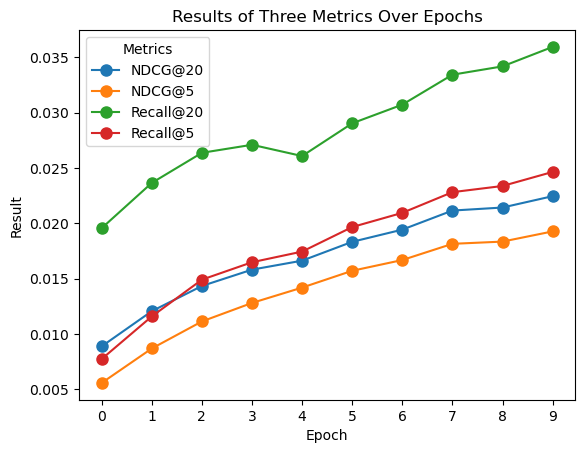

Peter4Coldstart(
  (item_embedding): Embedding(199006, 128, padding_idx=0)
  (residual_blocks): Sequential(
    (0): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(128, 128, kernel_size=(1, 3), stride=(1, 1))
      (ln1): LayerNorm((128,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(128, 128, kernel_size=(1, 3), stride=(1, 1), dilation=(2, 2))
      (ln2): LayerNorm((128,), eps=1e-08, elementwise_affine=True)
    )
    (1): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(128, 128, kernel_size=(1, 3), stride=(1, 1), dilation=(4, 4))
      (ln1): LayerNorm((128,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(128, 128, kernel_size=(1, 3), stride=(1, 1), dilation=(8, 8))
      (ln2): LayerNorm((128,), eps=1e-08, elementwise_affine=True)
    )
    (2): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(128, 128, kernel_size=(1, 3), stride=(1, 1))
      (ln1): LayerNorm((128,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(128, 128, kernel_siz

In [17]:
# define the paths to the target and source data files
args.source_path = 'Tenrec/ratings_Beauty.csv' 
args.item_min = 2
args.target_num = 1

train_loader, val_loader, test_loader = process_dataV6(args)

model = Peter4Coldstart(args)
trainV2( model, train_loader, val_loader, writer, args) 

#### **Observations**



- During the training process, the model's performance improves as indicated by the reduction in cross-entropy loss and the increase in recall and NDCG metrics. 

- At the beginning of training, the model has a high **cross-entropy loss** of 11.49359, meaning that its predicted probability distributions differ significantly from the actual distributions. However, as training progresses, the loss decreases considerably, reaching a minimum of 2.17636 after 10 epochs.

- The model's recall and NDCG values for the top 20 and top 5 recommendations also increase steadily with each epoch of training. 

- At the start of training, the **recall** values for the top 20 and top 5 recommendations are 0.019559 and 0.007729, respectively, but they improve to 0.035938 and 0.024637 after 10 epochs. 

- Similarly, the **NDCG** values for the top 20 and top 5 recommendations start at 0.0089 and 0.0056, respectively, but increase to 0.0224 and 0.0193 after 10 epochs.

- Taken together, these findings suggest that the model is becoming increasingly proficient at making predictions and recommendations as it undergoes additional training epochs.

## **Best Model**

**For the first way of preprocessing**

Based on the results of metrics, CE Loss, and time, it seems that **Epoch 9** is the best model:

- **Recall@20** is 0.02144252232142857 and **NDCG@20** is tensor(0.0127, device='cuda:0') , which is one of the highest performances achieved.

- **Recall@5** is 0.013239397321428571 and **NDCG@5** is tensor(0.0104, device='cuda:0'), which is one of the highest performances achieved.

- **Training CE Loss** is 2.56333, which is one of the lowest losses achieved.

- **one epoch train time** is 238.519118309021, which is خne of the shortest durations achieved.

- **Comparing to epoch 10**, it has slightly higher Recall@20, Recall@5, NDCG@20, and NDCG@5 values, but it has an even worse one epoch train time. So, I would select epoch 9 as the best model.

- This indicates that **Epoch 9** has the best performance in terms of the Recall and NDCG metrics, CE Loss, and train time. Which appears to be most important for this recommendation model.


**For the Second way of preprocessing**

Based on the results of metrics, CE Loss, and time, it seems that **Epoch 8** is the best model:

- **Recall@20** is 0.033426339285714285 and **NDCG@20** is tensor(0.0211, device='cuda:0'), which is one of the highest performances achieved.

- **Recall@5** is 0.022809709821428572 and **NDCG@5** is tensor(0.0181, device='cuda:0'), which is one of the highest performances achieved.

- **Training CE Loss** is 2.55025, one of the lowest losses achieved.

- **one epoch train time** is 238.519118309021, which is one of the shortest durations achieved.

- **Comparing to epoch 9 and 10**, they have slightly higher Recall@20, Recall@5, NDCG@20, and NDCG@5 values, but they have an even worse one epoch train time. So, I would select epoch 8 as the best model.

- In summary, based on the goal of maximizing Recall and NDCG and minimizing CE Loss and train time, **Epoch 8** shows the best model according to these results. 